# Lecture 3
## Likelihoods & numerical minimizer fitting
_(Written by Jean-Loup Tastet, 2019-02-11)_

In [1]:
# Python 2 compatibility
from __future__ import division
from __future__ import print_function

## Exercise 1

In [2]:
import numpy as np
from numpy.random import normal, seed # Gaussian RNG
from scipy.stats import norm # Gaussian PDF
import matplotlib.pyplot as plt

In [3]:
seed(42)

Draw random numbers according to a Gaussian distribution with mean $\mu=0.2$ and standard deviation $\sigma=0.1$.

In [4]:
true_mu = 0.2
true_sigma = 0.1

In [5]:
x = normal(loc=true_mu, scale=true_sigma, size=50)

Define the log-likelihood function:

$$\mathrm{LLH}(\mu, \sigma | x) = \sum_i \ln(f(x_i; \mu,\sigma))$$

In [6]:
def llh(x, mu, sigma):
    # Sum over the first dimension.
    # This will be useful when mu and sigma will be arrays.
    return np.sum(np.log(norm.pdf(x, loc=mu, scale=sigma)), axis=0)

LLH at the true parameter values. This is usually *not* the maximum LLH.

In [7]:
llh(x, true_mu, true_sigma)

46.55379978123649

### Analytical maximum likelihood estimator (MLE)

In the case of a Gaussian distribution, the MLE reduces to:
$$\mu = \bar{x} = \frac{1}{N} \sum_i x_i$$
$$\sigma = \sqrt{\mathrm{Var}(x)} = \left( \frac{1}{N} \sum_i (x_i-\mu)^2 \right)^{\frac{1}{2}}$$

In [8]:
def analytical_mle(x):
    mu_ana = np.mean(x)
    sigma_ana = np.std(x)
    return llh(x, mu_ana, sigma_ana), mu_ana, sigma_ana

### Raster scan

We want to scan over a $\mu \times \sigma$ grid.

We will use `numpy.meshgrid` for that. This is not necessary here (we could just use NumPy array broadcasting), but it will prove useful for 2D plots. A `for` loop would work as well, but would be slower.

In [9]:
mu_range = np.linspace(start=0, stop=0.5, num=100) # Uniform range
sigma_range = np.geomspace(start=0.01, stop=1, num=100) # Log-uniform range since σ > 0

This creates two grids, containing the values of $\mu$ and $\sigma$ at each point.

$\mu$ varies along the first dimension, and $\sigma$ along the second.

We need to pass `indexing='ij'` to use the usual broadcasting rules, since by default `np.meshgrid` transposes the result (which can sometimes be useful when plotting.)

In [10]:
mu, sigma = np.meshgrid(mu_range, sigma_range, indexing='ij')

Now we want to reserve the first dimension for summing over the data points, with μ varying over the second dimension and σ over the third.

Data (`x`) is a 1D array, which is equivalent to a 3D array with the two trailing dimensions set to unity. Let's explicitly write it as such.

In [11]:
x_3d = x[:,np.newaxis,np.newaxis]

Similarly, add a leading dimension to `mu` and `sigma` (to avoid summing over it when computing the LLH).

In [12]:
mu_3d = mu[np.newaxis,:,:]
sigma_3d = sigma[np.newaxis,:,:]

Evaluate the LLH over the grid.

Since we sum over the first dimension (data), the result is a 2D array corresponding to the $\mu \times \sigma$ grid.

In [13]:
raster_llh = llh(x_3d, mu_3d, sigma_3d)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


Find the location of the maximum (ignoring NaN's).

This returns a linear index (flattened array), so we need to convert it back to a 2D index (thanks NumPy...).

In [14]:
raster_max_linear_idx = np.nanargmax(raster_llh)
id_mu, id_sigma = np.unravel_index(raster_max_linear_idx, raster_llh.shape)

Find the maximum and the corresponding parameters.

In [15]:
raster_max_mu  = mu_range[id_mu]
raster_max_sigma = sigma_range[id_sigma]
raster_max_llh = raster_llh[id_mu, id_sigma]
print('Maximum LLH (raster): {:.3} reached at μ = {:.3} and σ = {:.3}'.
      format(raster_max_llh, raster_max_mu, raster_max_sigma))

Maximum LLH (raster): 48.1 reached at μ = 0.177 and σ = 0.0933


Seems good! Let's plot the LLH landscape to double-check this result.

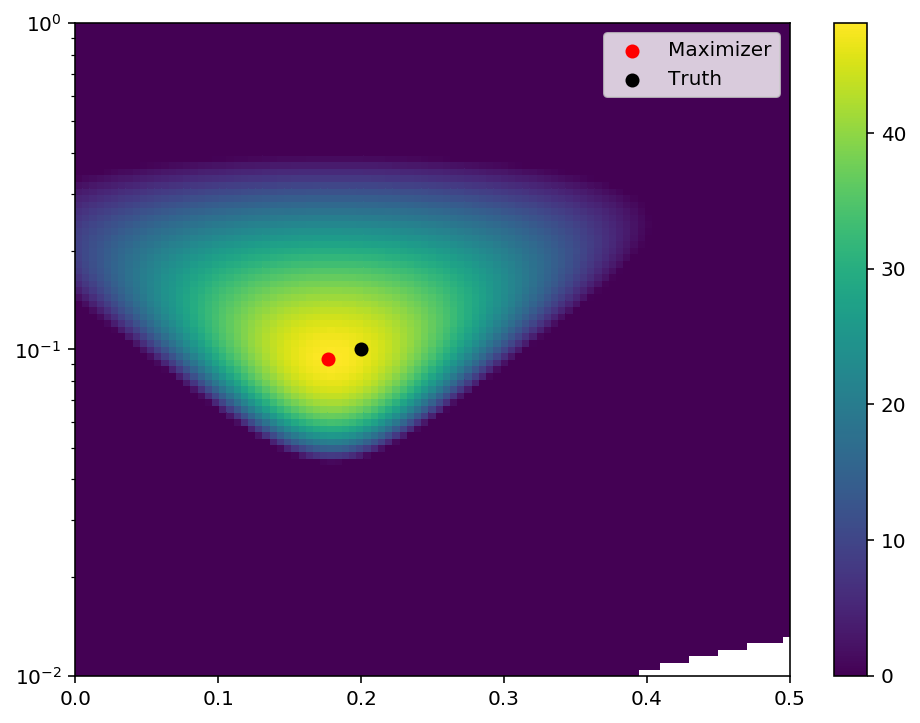

In [16]:
raster_fig, raster_ax = plt.subplots(figsize=(8,6))
raster_plot = raster_ax.pcolormesh(mu, sigma, raster_llh, vmin=0)
raster_ax.scatter([raster_max_mu], [raster_max_sigma], color='r', label='Maximizer')
raster_ax.scatter([true_mu], [true_sigma], color='k', label='Truth')
raster_ax.set_yscale('log')
raster_fig.colorbar(raster_plot)
raster_ax.legend()

### Comparison to input values

Let's put everything into a function.

In [17]:
def raster_scan(data, mu_range, sigma_range):
    mu, sigma = np.meshgrid(mu_range, sigma_range, indexing='ij')
    x_3d = data[:,np.newaxis,np.newaxis]
    mu_3d = mu[np.newaxis,:,:]
    sigma_3d = sigma[np.newaxis,:,:]
    raster_llh = llh(x_3d, mu_3d, sigma_3d)
    raster_max_linear_idx = np.nanargmax(raster_llh)
    id_mu, id_sigma = np.unravel_index(raster_max_linear_idx, raster_llh.shape)
    raster_max_mu  = mu_range[id_mu]
    raster_max_sigma = sigma_range[id_sigma]
    raster_max_llh = raster_llh[id_mu, id_sigma]
    return raster_max_llh, raster_max_mu, raster_max_sigma

In [18]:
N_iterations = 200
max_raster_llhs = np.zeros(N_iterations)
max_analytical_llhs = np.zeros(N_iterations)
true_llhs = np.zeros(N_iterations)
for i in range(N_iterations):
    new_x = normal(loc=true_mu, scale=true_sigma, size=50)
    true_llhs[i] = llh(new_x, true_mu, true_sigma)
    max_raster_llhs[i], _, _ = raster_scan(new_x, mu_range, sigma_range)
    max_analytical_llhs[i], _, _ = analytical_mle(new_x)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


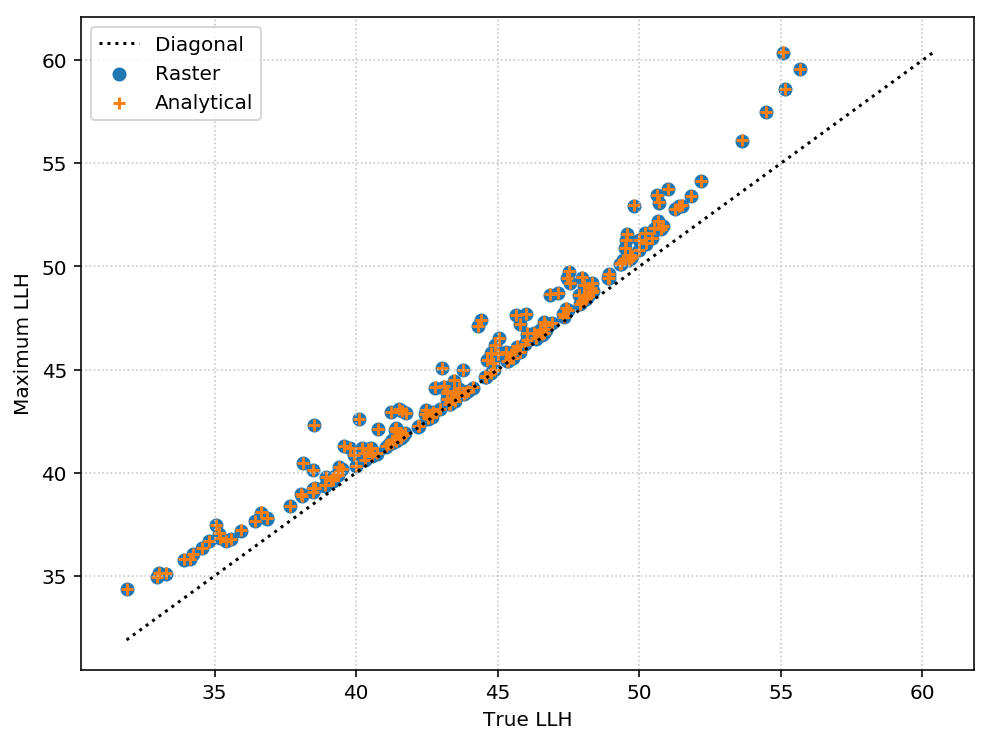

In [19]:
fig_llh, ax_llh = plt.subplots(figsize=(8,6))
ax_llh.scatter(true_llhs, max_raster_llhs, label='Raster')
ax_llh.scatter(true_llhs, max_analytical_llhs, label='Analytical', marker='+')
ax_llh.set_xlabel('True LLH')
ax_llh.set_ylabel('Maximum LLH')
ax_llh.grid(color='60', linestyle=':')
rg_llh = np.linspace(np.min(true_llhs), np.max(max_analytical_llhs), num=100)
ax_llh.plot(rg_llh, rg_llh, label='Diagonal', linestyle=':', color='k')
ax_llh.legend()

In [20]:
dllh_raster = np.mean(max_raster_llhs - true_llhs)
dllh_analytical = np.mean(max_analytical_llhs - true_llhs)
print('Average ΔLLH: {:+.2} (raster)'.format(dllh_raster))
print('Average ΔLLH: {:+.2} (analytical)'.format(dllh_analytical))

Average ΔLLH: +0.94 (raster)
Average ΔLLH: +0.95 (analytical)
